<div style="border-radius: 10px; border: #4E5672 solid; padding: 15px; background-color: #800080; text-align: center;">
    <h1 style="color: #FFFFFF; font-size: 150%;">Churn Prediction Project</h1>
</div>

<div style="border-radius: 10px; border: #4E5672 solid; padding: 15px; background-color: #800080; font-size: 100%; text-align: left; color: #FFFFFF;">
    <p>
        This project encompasses data on customer churn from a fictional telecommunication company operating in California during the third quarter. The company provides home phone and internet services to a total of 7043 customers, indicating which customers left, stayed, or subscribed to services. The aim is to predict customer churn using a machine learning model.
    </p>
</div>


# <p style="background-color:#2E2E2E; font-family:'Courier New', monospace; color:#00FFFF; font-size:160%; text-align:center; padding: 10px; border-radius: 20px;"> 📖 Reading and Cleaning 🧹 </p>

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import optuna
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=Warning)


In [91]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<div style="border-radius: 10px; border: #4E5672 solid; padding: 15px; background-color: #800080; font-size: 100%; text-align: left; color: #FFFFFF;">
   <p>
        <strong>Variable Descriptions:</strong>
        <ul>
            <li>CustomerId: Customer ID</li>
            <li>Gender: Gender</li>
            <li>SeniorCitizen: Whether the customer is a senior citizen (1, 0)</li>
            <li>Partner: Whether the customer has a partner (Yes, No)</li>
            <li>Dependents: Whether the customer has dependents (Yes, No)</li>
            <li>Tenure: Number of months the customer has stayed with the company</li>
            <li>PhoneService: Whether the customer has phone service (Yes, No)</li>
            <li>MultipleLines: Whether the customer has multiple lines (Yes, No, No phone service)</li>
            <li>InternetService: Type of internet service provider (DSL, Fiber optic, No)</li>
            <li>OnlineSecurity: Whether the customer has online security (Yes, No, No internet service)</li>
            <li>OnlineBackup: Whether the customer has online backup (Yes, No, No internet service)</li>
            <li>DeviceProtection: Whether the customer has device protection (Yes, No, No internet service)</li>
            <li>TechSupport: Whether the customer has technical support (Yes, No, No internet service)</li>
            <li>StreamingTV: Whether the customer has streaming TV (Yes, No, No internet service)</li>
            <li>StreamingMovies: Whether the customer has streaming movies (Yes, No, No internet service)</li>
            <li>Contract: Contract term of the customer (Month-to-month, One year, Two years)</li>
            <li>PaperlessBilling: Whether the customer has paperless billing (Yes, No)</li>
            <li>PaymentMethod: Payment method of the customer (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))</li>
            <li>MonthlyCharges: Monthly amount billed to the customer</li>
            <li>TotalCharges: Total amount billed to the customer</li>
            <li>Churn: Whether the customer churned (Yes or No)</li>
        </ul>
   </p>
</div>


In [92]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

<div style="border-radius: 10px; border: #4E5672 solid; padding: 15px; background-color: #800080; font-size: 100%; text-align: left; color: #FFFFFF;">
    <p>
        TotalCharges column type should be numeric
    </p>
</div>

In [93]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [94]:
num_cols = [col for col in df.columns if (df[col].dtype in ["int64","float64"]) & (df[col].nunique()>10)]
num_cols


['tenure', 'MonthlyCharges', 'TotalCharges']

In [95]:
cat_cols = [col for col in df.columns if df[col].nunique()<10]
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

# <p style="background-color:#2E2E2E; font-family:'Courier New', monospace; color:#00FFFF; font-size:150%; text-align:center; padding: 10px; border-radius: 20px;"> 📊 Exploratory Data Analysis (EDA) 📊 </p>

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#800080; font-size:150%; text-align:left;padding: 0px;">Target</p>

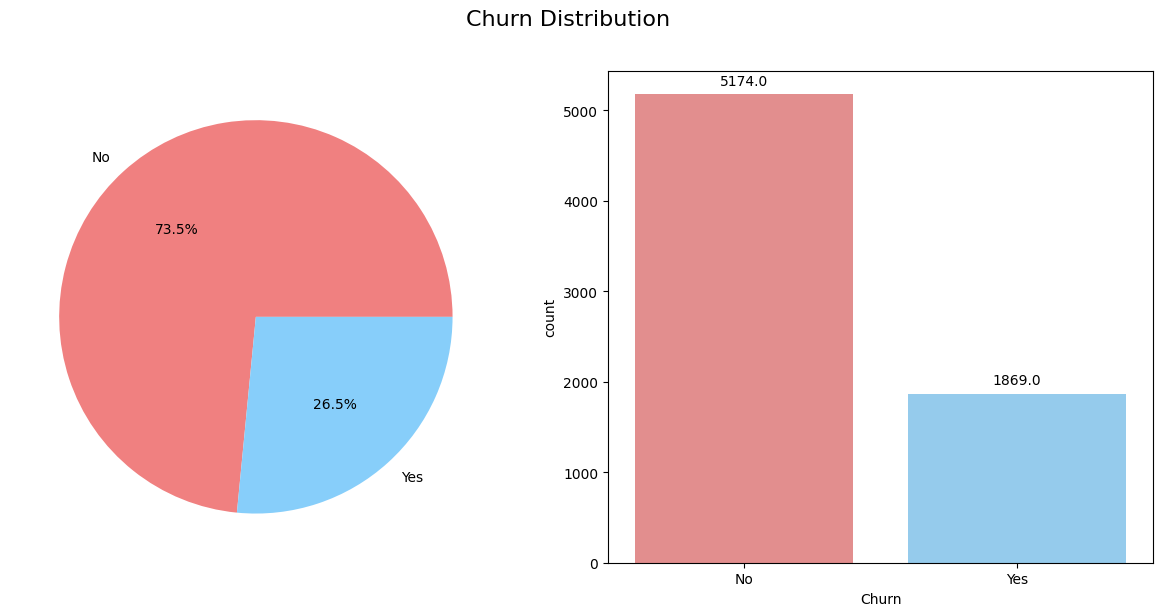

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 

churn_counts = df['Churn'].value_counts()
axes[0].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])

sns.countplot(data=df, x='Churn', palette=['lightcoral', 'lightskyblue'], ax=axes[1])

for p in axes[1].patches:
    axes[1].annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

fig.suptitle("Churn Distribution", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#800080; font-size:150%; text-align:left;padding: 0px;">Categorical</p>

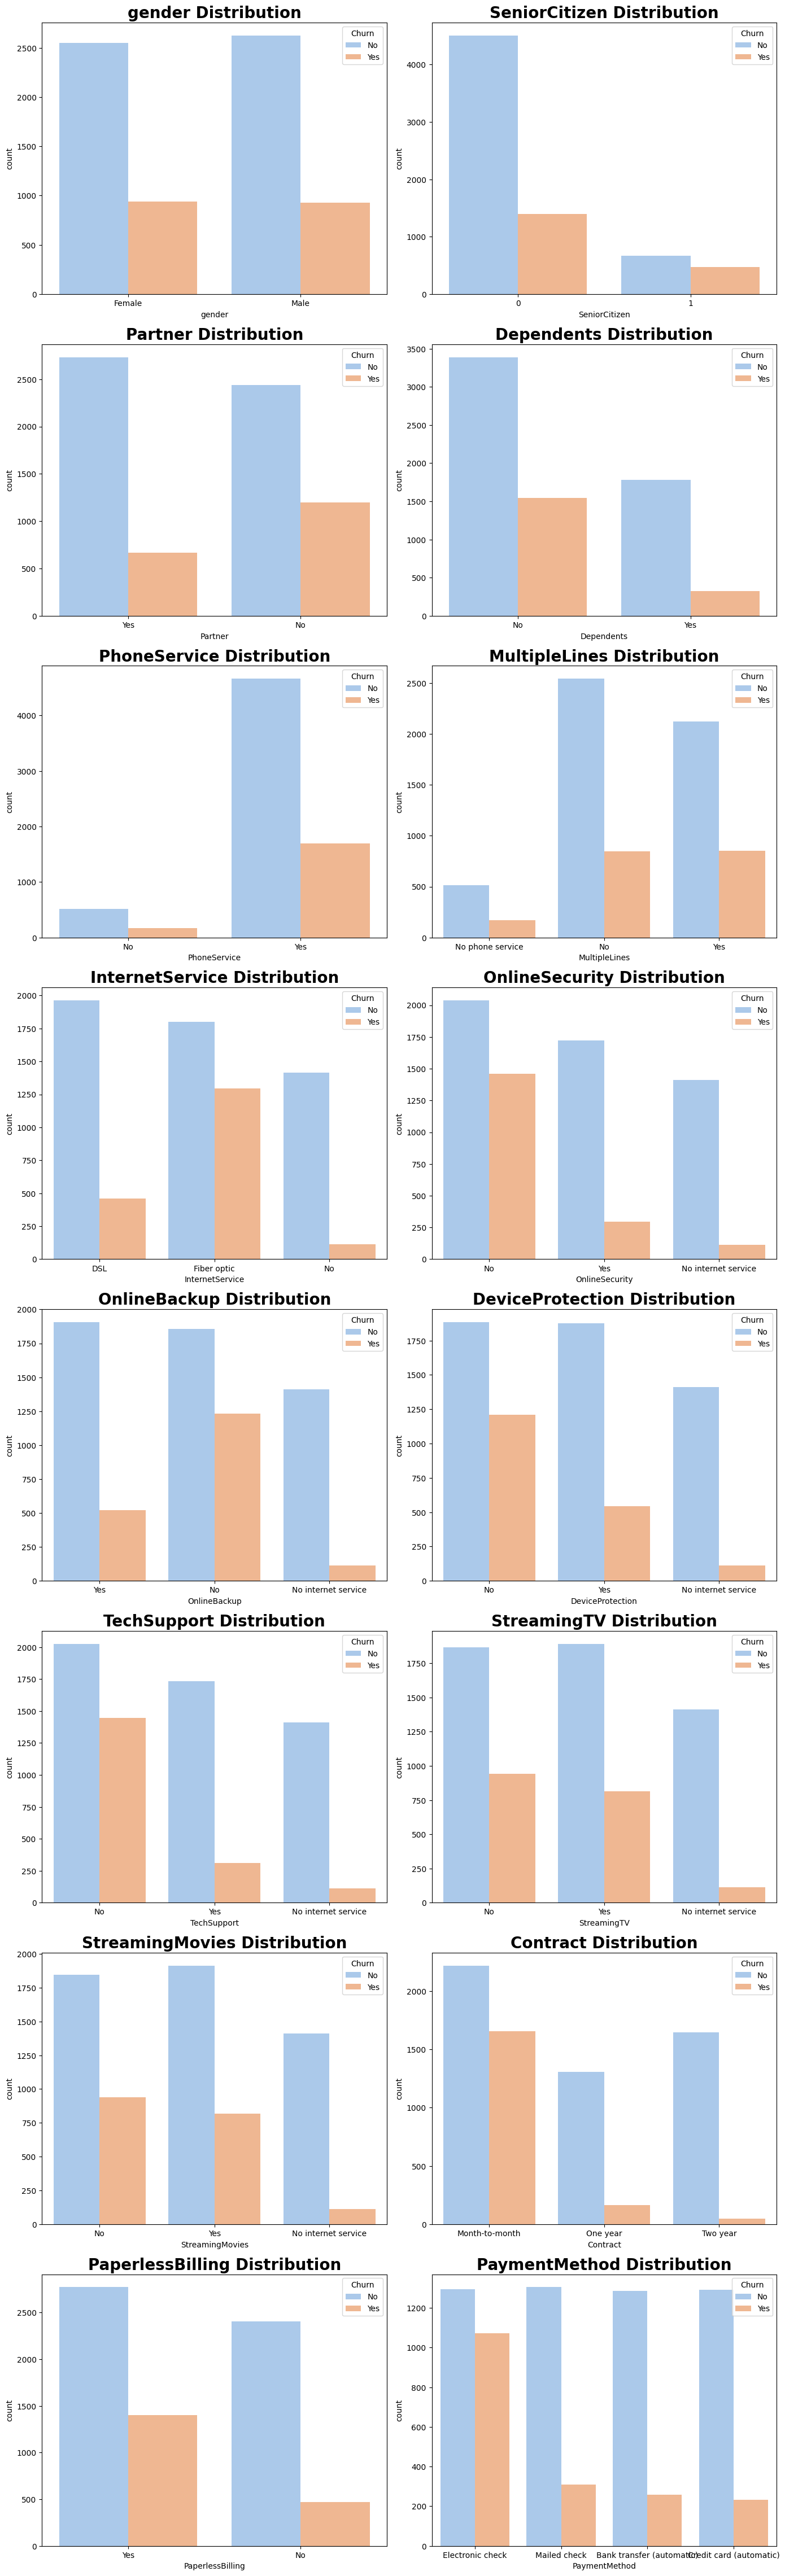

In [97]:
plt.figure(figsize=(14,len(cat_cols)*3))
for idx,column in enumerate(cat_cols[:-1]):
    plt.subplot(len(cat_cols)//2+1,2,idx+1)
    sns.countplot(hue="Churn", x=column, data=df, palette="pastel")
    plt.title(f"{column} Distribution",weight='bold',fontsize=20)
    plt.tight_layout()

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#800080; font-size:150%; text-align:left;padding: 0px;">Numerical</p>

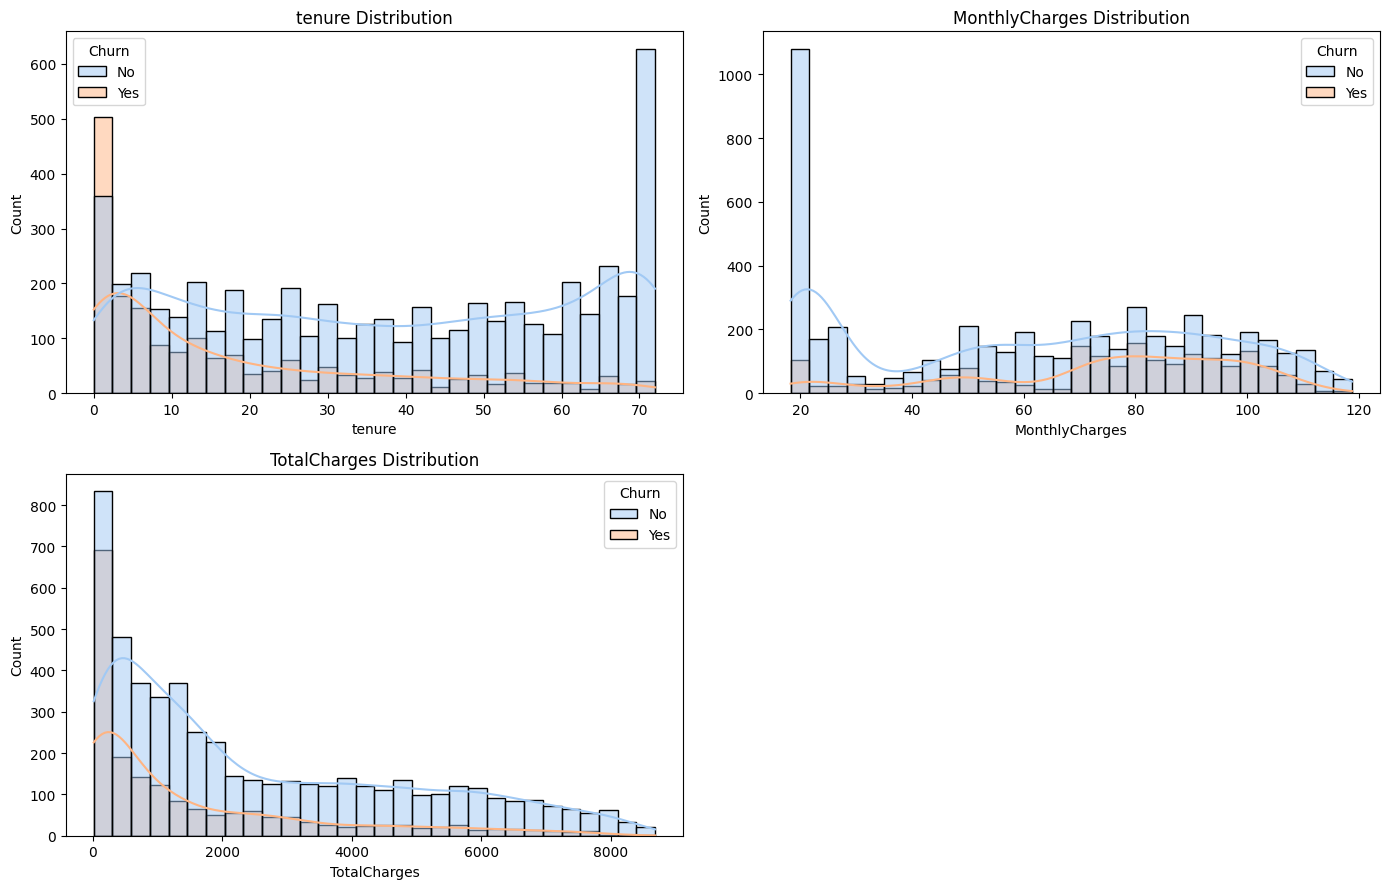

In [98]:
plt.figure(figsize=(14,len(num_cols)*3))
for idx,column in enumerate(num_cols):
    plt.subplot(len(num_cols)//2+1,2,idx+1)
    sns.histplot(x=column, hue="Churn", data=df,bins=30,kde=True, palette="pastel")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

In [99]:
scatter_fig = px.scatter(
    df,
    x="TotalCharges",
    y="tenure",
    size="MonthlyCharges",
    color="Churn",
    hover_name=df.index,
    log_x=True,
    size_max=60,
    title='Scatter Plot: Churn Status, TotalCharges, tenure, and MonthlyCharges',
)

scatter_fig.show()

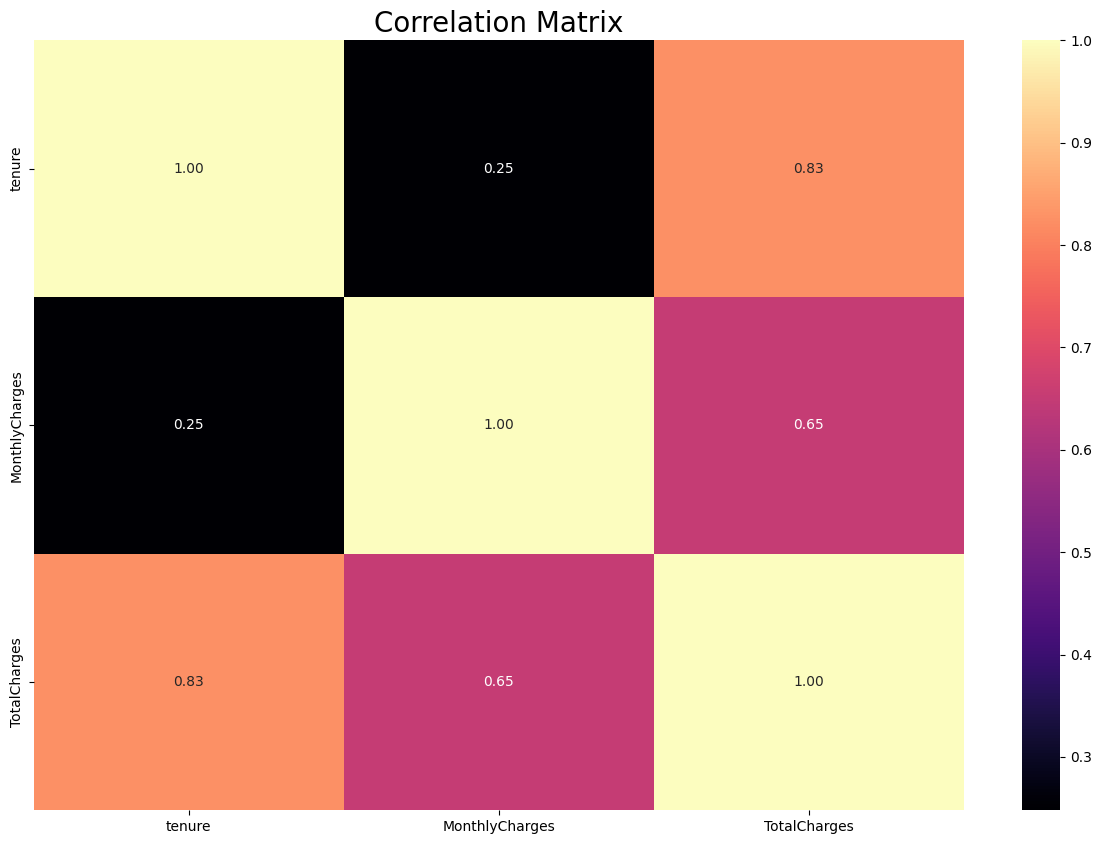

In [100]:
df[num_cols].corr()
f, ax = plt.subplots(figsize=[15, 10])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()


# <p style="background-color:#2E2E2E; font-family:'Courier New', monospace; color:#00FFFF; font-size:150%; text-align:center; padding: 10px; border-radius: 20px;"> 🛠️ Feature Engineering 🛠️</p>

In [101]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)


              n_miss  ratio
TotalCharges      11   0.16


In [102]:
df['TotalCharges'].fillna(0, inplace=True)
df["tenure"] = df["tenure"] + 1

In [103]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [104]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

tenure False
MonthlyCharges False
TotalCharges False


# <p style="background-color:#2E2E2E; font-family:'Courier New', monospace; color:#00FFFF; font-size:150%; text-align:center; padding: 10px; border-radius: 20px;"> 🛠️ Modeling 🤖</p>

In [105]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [106]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

In [107]:
def convert_to_binary(dataframe, categorical_cols):
    for col in categorical_cols:
        unique_values = dataframe[col].unique()
        for val in unique_values:
            new_col_name = f"{col}_{val}"
            dataframe[new_col_name] = (dataframe[col] == val).astype(int)
        dataframe.drop(col, axis=1, inplace=True)
    return dataframe

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = convert_to_binary(df, ohe_cols)

In [108]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

,tenure,MonthlyCharges,TotalCharges
0,-1.277445,-1.160323,-0.992611
1,0.066327,-0.259629,-0.172165
2,-1.236724,-0.362660,-0.958066
3,0.514251,-0.746535,-0.193672
4,-1.236724,0.197365,-0.938874


In [109]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=17)

0.827503394215744

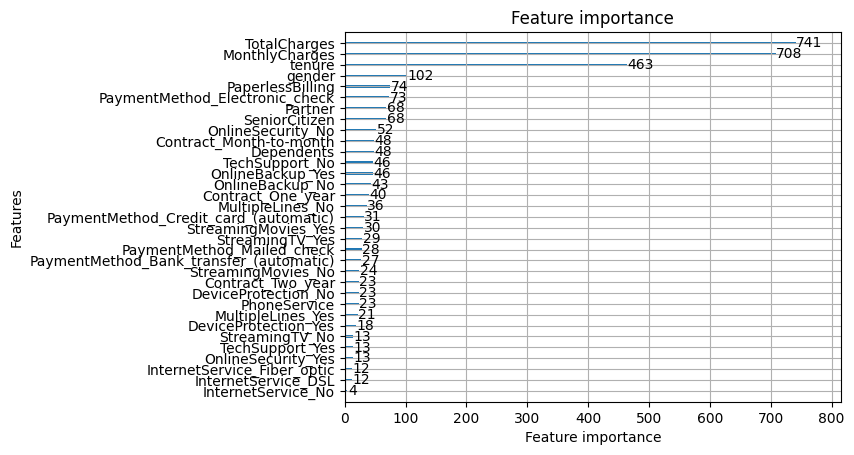

In [110]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier(metric = "auc", random_state=17)
lgb.fit(X_train, y_train)
lightgbm.plot_importance(lgb);
roc_auc_score(y_val,lgb.predict_proba(X_val)[:,1])

0.8218011117657607

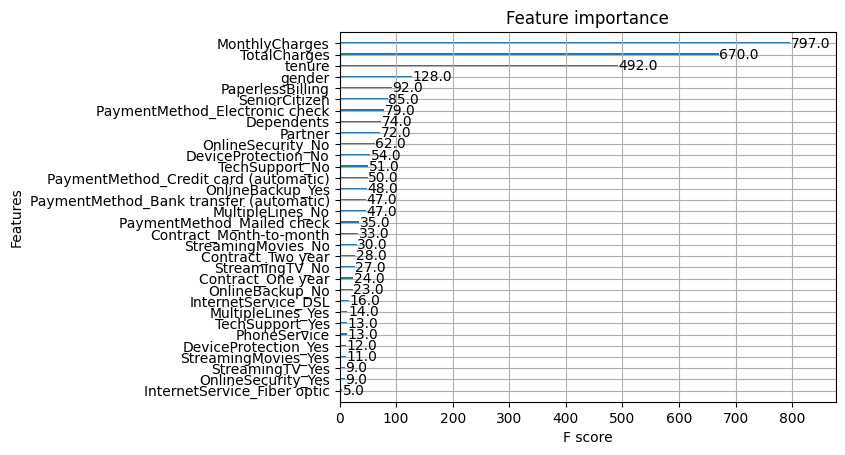

In [111]:
import xgboost as xgb
xgb = xgb.XGBClassifier(eval_metric="auc")
xgb.fit(X_train, y_train)
xgboost.plot_importance(xgb);
roc_auc_score(y_val,xgb.predict_proba(X_val)[:,1])

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#800080; font-size:150%; text-align:left;padding: 0px;">LightGBM Classifier</p>

In [112]:
from lightgbm import LGBMClassifier
def objective_lgb(trial):
    
    lgb_params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),

    }

    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc


In [113]:
study_lgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgb.optimize(objective_lgb, n_trials=50)

In [114]:
print('Best parameters', study_lgb.best_params)

Best parameters {'learning_rate': 0.003540789248187181, 'max_depth': 16, 'n_estimators': 996, 'colsample_bytree': 0.33911611213313875}


In [115]:
lgbm_final = LGBMClassifier(**study_lgb.best_params)
lgbm_final.fit(X_train, y_train)
y_pred = lgbm_final.predict_proba(X_val)[:,1]

print('Accuracy: ', roc_auc_score(y_val, y_pred))

Accuracy:  0.8329828111791377


<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#800080; font-size:150%; text-align:left;padding: 0px;">XGBoost Classifier</p>

In [116]:
from xgboost import XGBClassifier
def objective_xgb(trial):
    
    xgb_params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0)
    }

    model = XGBClassifier(**xgb_params)

    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc


In [117]:
study_xgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xgb, n_trials=50)

In [118]:
print('Best parameters', study_xgb.best_params)

Best parameters {'learning_rate': 0.019999266248136895, 'max_depth': 3, 'n_estimators': 564, 'colsample_bytree': 0.2662822410792135}


In [119]:
xgb_final = XGBClassifier(**study_xgb.best_params)
xgb_final.fit(X_train, y_train)
y_pred = xgb_final.predict_proba(X_val)[:,1]

print('Accuracy: ', roc_auc_score(y_val, y_pred))

Accuracy:  0.8360542562184594


<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#800080; font-size:150%; text-align:left;padding: 0px;">Voting Classifier</p>

In [120]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[
                                      ('lgbm', lgbm_final), 
                                      ('xgb', xgb_final)], voting='soft')
voting.fit(X_train,y_train)
voting_pred = voting.predict_proba(X_val)[:,1]

print('Accuracy: ', roc_auc_score(y_val, voting_pred))

Accuracy:  0.8352114660450342
